In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, GlobalAveragePooling2D)
import tensorflow as tf

In [2]:
data_path = "train/"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])

In [3]:
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list

In [4]:
data_list.head(3)

,img_path,label
0,type1\AX20211214072921_1216.png,type1
1,type1\AX20211214072921_1217.png,type1
2,type1\AX20211214072921_1218.png,type1


In [5]:
data_list['label'] = data_list['label'].astype('string')
type(data_list['label'][0])

str

In [6]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                                         test_size=0.1,
                                         random_state=42,
                                         stratify=data_list['label'].values)

In [7]:
img_size = 256
num_class = len(data_list['label'].unique())
print(num_class)

4


In [8]:
from tensorflow.keras.applications.resnet import (ResNet50,ResNet101, preprocess_input)

In [9]:
resnet_model = ResNet101(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(resnet_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=resnet_model.inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [12]:
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 100

In [13]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=test_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 1800 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


In [15]:
model_dir = 'model-logs/vbn'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [16]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

c:\Users\Lucas\anaconda3\envs\tensorflow_new\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
c:\Users\Lucas\anaconda3\envs\tensorflow_new\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
57/57 [==============================] - 46s 575ms/step - loss: 1.4507 - accuracy: 0.3433 - val_loss: 1.4609 - val_accuracy: 0.2600
Epoch 2/100
57/57 [==============================] - 27s 477ms/step - loss: 0.8845 - accuracy: 0.6617 - val_loss: 1.4863 - val_accuracy: 0.2300
Epoch 3/100
57/57 [==============================] - 27s 475ms/step - loss: 0.6228 - accuracy: 0.7894 - val_loss: 1.6339 - val_accuracy: 0.3050
Epoch 4/100
57/57 [==============================] - 27s 476ms/step - loss: 0.4247 - accuracy: 0.9006 - val_loss: 1.3804 - val_accuracy: 0.4300
Epoch 5/100
57/57 [==============================] - 27s 476ms/step - loss: 0.3015 - accuracy: 0.9511 - val_loss: 1.0605 - val_accuracy: 0.5350
Epoch 6/100
57/57 [==============================] - 27s 475ms/step - loss: 0.2119 - accuracy: 0.9778 - val_loss: 0.8766 - val_accuracy: 0.6300
Epoch 7/100
57/57 [==============================] - 27s 476ms/step - loss: 0.1322 - accuracy: 0.9928 - val_loss: 0.7428 - val_accuracy:

In [17]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)

c:\Users\Lucas\anaconda3\envs\tensorflow_new\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


7/7 - 1s - loss: 0.6936 - accuracy: 0.7550


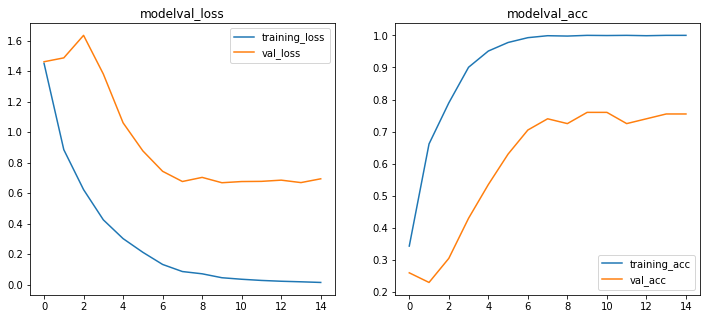

In [18]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()